# Assignment 07: Due Monday 10/14

In this assignment we will look at some siumulated $\pi^-$ data from the electron-ion collider (EIC) experiment ePIC. We will use a subset of the ePIC simulation data to assess the tracking performance, specifically the momentum resolutions, of the ePIC tracking system. 

For curious readers interested in seeing the code framework of a developing experiment (not needed for the assignemt)

* ePIC geometry/GEANT simulation code: https://github.com/eic/epic

* ePIC reconstruction code: https://github.com/eic/EICrecon


## Imports 

For this assignemnt you will need the following imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
%matplotlib inline

import scipy.special as sf
import seaborn as sns

# Problem 1A)

Create a Pandas DataFrame object from the data file *epic_3511.csv*, located in the *data* dircetroy, and use the *info* function to list the information from the DataFrame.

In [39]:
df=pd.read_csv('/Users/Maxwe/Desktop/Stuff 3.0/Temple Stuff/Scientific Computing II/epic_3511.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92293 entries, 0 to 92292
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Event    92293 non-null  int64  
 1   p_gen    92293 non-null  float64
 2   eta_gen  92293 non-null  float64
 3   p_rec    92293 non-null  float64
 4   eta_rec  92293 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.5 MB


# Problem 1B)

Now explore the data a little bit. 
1. Are there any NAN or NULL values to worry about?
2. Use the DataFrame *hist()* method to histogram the DataFrame quantities.
3. Use DataFrame *cor()* method to investigate if any quantites are correlated? What quantity pairs show a strong correlation?

In [40]:
print(df.isnull().sum())

Event      0
p_gen      0
eta_gen    0
p_rec      0
eta_rec    0
dtype: int64


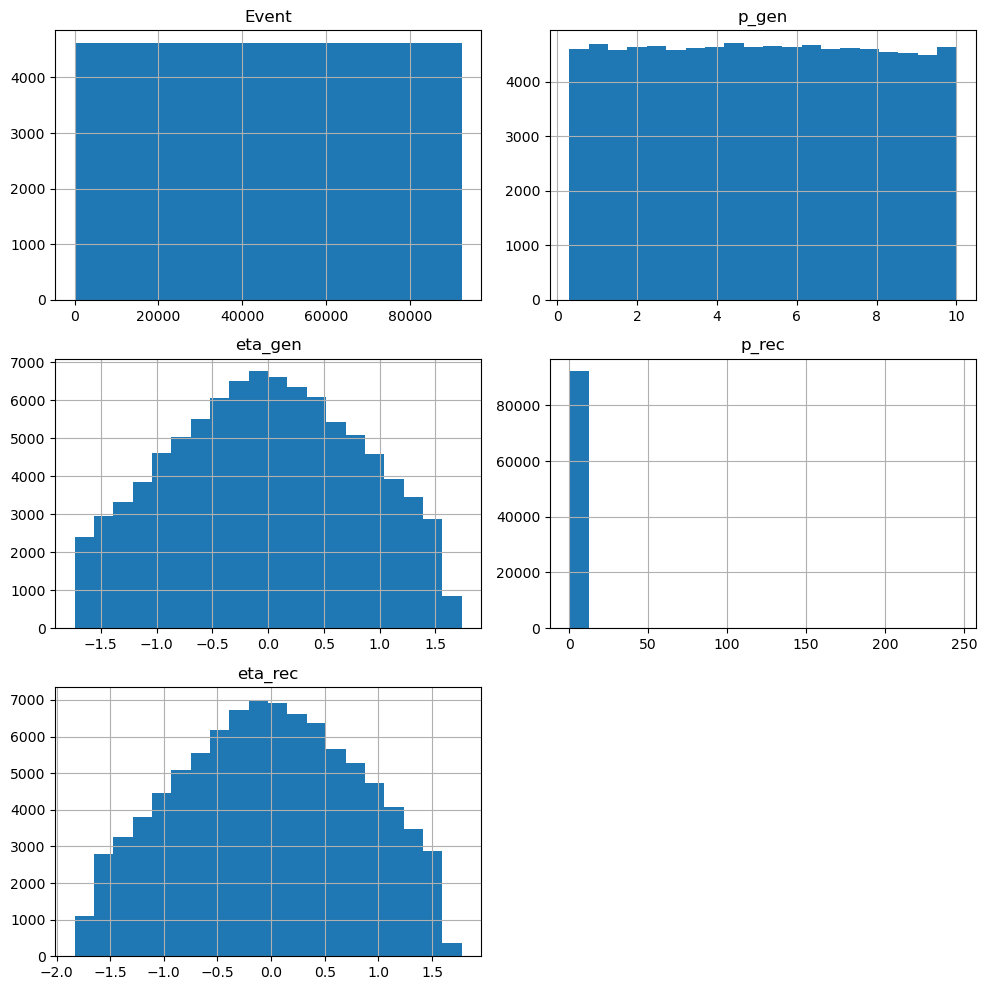

            Event     p_gen   eta_gen     p_rec   eta_rec
Event    1.000000 -0.003699 -0.000766 -0.001957 -0.000764
p_gen   -0.003699  1.000000  0.005566  0.929444  0.005553
eta_gen -0.000766  0.005566  1.000000  0.006302  0.999996
p_rec   -0.001957  0.929444  0.006302  1.000000  0.006292
eta_rec -0.000764  0.005553  0.999996  0.006292  1.000000


In [41]:
df.hist(figsize=(10,10),bins=20)
plt.tight_layout()
plt.show()
correlation_matrix=df.corr()
print(correlation_matrix)

# Problem 1C)
Visualize the correlation by generating a heatmap of the correlation table. To do this we will use the Seaborn heatmap method *heatmap*

Your heatmap should look something like: 
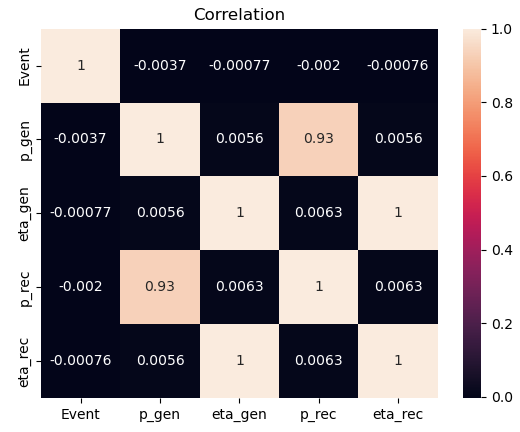

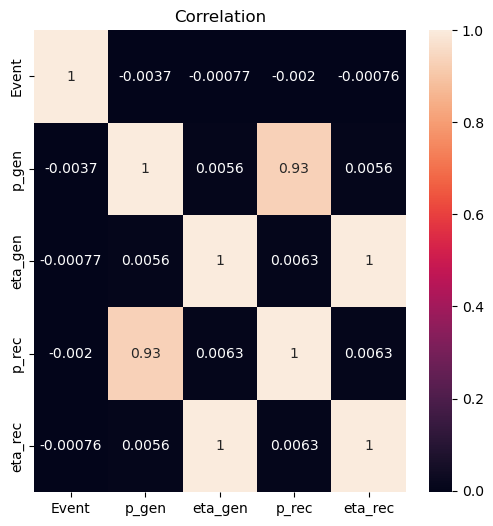

In [42]:
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation')
plt.show()

# Problem 2A)

In this assignment we will assess the tracking performance by calculating the momentum resolution. 
Define a new series in the DataFrame that calculates the momentum resolution and name it *p\_diff*, which should be defiend as
$$ \mathrm{p\_diff} = 100*(\mathrm{p\_rec} - \mathrm{p\_gen})/\mathrm{p\_gen} $$ 

This will give the difference between the reconstructed and generated momentum in percent.

Verify that this quantity is now defined and populated in your DataFrame.

In [43]:
df['p_diff']=100*(df['p_rec']-df['p_gen'])/df['p_gen']
print(df[['p_diff']].head())

     p_diff
0  0.045614
1  0.412629
2  0.459539
3 -0.025912
4 -0.739247


# Problem 2B)
1. Generate a histogram of the momentum difference. When creating the histogram use 100 bins and histogram range from -1% to +1%. Hint: Look at the matplotlib *hist()* method reference to see how to specify a histogram bin range.

2. Create x, y, and y_error arrays, where x contains the bin centers of the histogram bins, y is the counts in each bin, and y_error is the square root of the counts in each bin (e.g. $\sqrt{y}$). These will be used later for fitting purposes. 

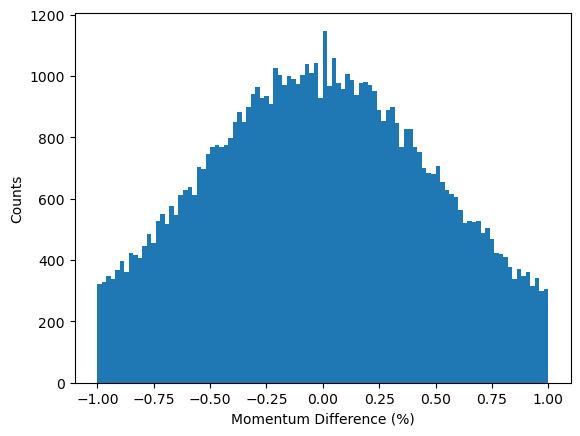

x (bin centers): [-0.99 -0.97 -0.95 -0.93 -0.91 -0.89 -0.87 -0.85 -0.83 -0.81 -0.79 -0.77
 -0.75 -0.73 -0.71 -0.69 -0.67 -0.65 -0.63 -0.61 -0.59 -0.57 -0.55 -0.53
 -0.51 -0.49 -0.47 -0.45 -0.43 -0.41 -0.39 -0.37 -0.35 -0.33 -0.31 -0.29
 -0.27 -0.25 -0.23 -0.21 -0.19 -0.17 -0.15 -0.13 -0.11 -0.09 -0.07 -0.05
 -0.03 -0.01  0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19
  0.21  0.23  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43
  0.45  0.47  0.49  0.51  0.53  0.55  0.57  0.59  0.61  0.63  0.65  0.67
  0.69  0.71  0.73  0.75  0.77  0.79  0.81  0.83  0.85  0.87  0.89  0.91
  0.93  0.95  0.97  0.99]
y (counts): [ 322  328  348  337  366  398  362  424  417  406  445  485  457  527
  551  518  577  547  611  628  637  613  703  698  747  770  774  769
  774  797  849  883  849  898  940  963  929  934  910 1026 1004  972
 1000  992  975 1003 1040 1011 1043  930 1148  969 1058  976  958 1008
  986  937  978  981  971  950  891  854  889  898  846  769  829  827
  770 

In [44]:
plt.hist(df['p_diff'],bins=100,range=(-1,1))
plt.xlabel('Momentum Difference (%)')
plt.ylabel('Counts')
plt.show()
counts,bin_edges=np.histogram(df['p_diff'],bins=100,range=(-1,1))
x=(bin_edges[1:]+bin_edges[:-1])/2
y=counts
y_error=np.sqrt(y)
print(f"x (bin centers): {x}")
print(f"y (counts): {y}")
print(f"y_error: {y_error}")

# Problem 3A)

The momentum distribution appears to follow a Gaussian distribution, and so the momnetum resolution provided by the tracking system can be calculated from the width of the distribution. We will fit the momentum distribution with a Gaussian function and extract the value of the Gaussian $\sigma$, which is the momentum resolutuon of the tracking system.

1. Define a function that returns a value computed from a Gaussian distribution. The Gaussian function should have the form:
$$ G(x) =  p_1 e^{-(x-p_2)^2/(2p_3)}$$,

where $x$ will be the momentum difference, $p_1,p_2,$ and $p_3$ are parameters determining the specific form of the Gaussian curve which will be optimized during fitting of the momentum difference distribution.

Your function should take x, p_1, p_2, and p_3 as arguments and return the output of $G(x)$.

In [45]:
def gaussian(x,p1,p2,p3):
    return p1*np.exp(-(x-p2)**2/(2*p3**2))

# Problem 3B)

Starting with the inital paramters $$p1=500, p2=0, p3=1$$ ,fit the momentum difference distribution using *curve_fit* from the Scipy library.

**Q: What is the momentum resolution?** 

In [46]:
initial_parameters=[500,0,1]
params,covariance=curve_fit(gaussian,x,y,p0=initial_parameters)
p1,p2,p3=params
momentum_resolution=p3
print(f"Fitted parameters are: p1 = {p1}, p2 = {p2}, p3 = {p3},\nMomentum resolution is: {momentum_resolution}")

Fitted parameters are: p1 = 1009.0567205629607, p2 = -0.022309876158301354, p3 = 0.6105187259317894,
Momentum resolution is: 0.6105187259317894


# Problem 3C)
1. Draw a histogram of the distribution with the fit result drawn on as well.
2. Calculate the reduced $\chi^2$ of the fit.
3. Calculate the p-value of the fit.
**Q: Does the fit do a good job describing the data within the $\pm1\%$ range? Explain**
Fitted histogram over $\pm1 \%$ range should look like this:
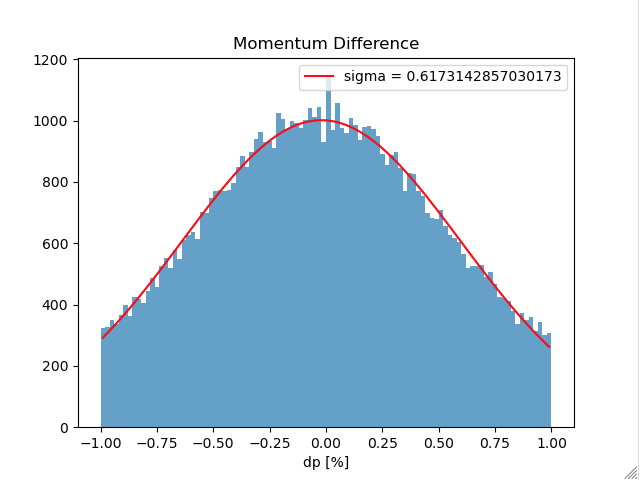

**Q: What happens to how the fit describes the data if we open up the range to cover from -5% to 5%, is it worst or better? What does this say about our assumption that the distribution is purely Gaussian?**

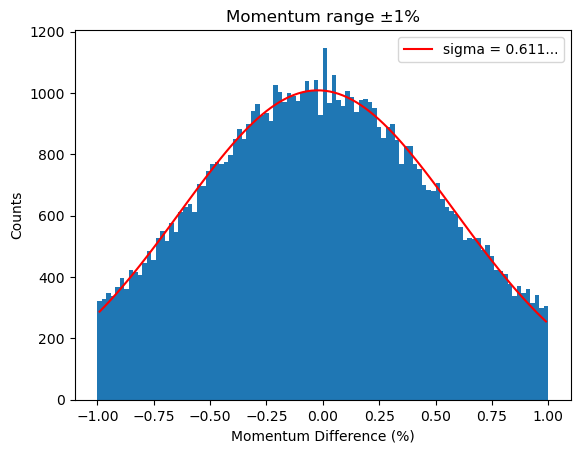

This is what a ±1% range should look like


In [47]:
plt.hist(df['p_diff'],bins=100,range=(-1, 1))
plt.plot(x, gaussian(x,*params),label='sigma = 0.611...',color='red')
plt.xlabel('Momentum Difference (%)')
plt.ylabel('Counts')
plt.title('Momentum range ±1%')
plt.legend()
plt.show()
print('This is what a ±1% range should look like')

In [48]:
chi_squared=np.sum(((y-gaussian(x,*params))/y_error)**2)
dof=len(x)-len(params) 
reduced_chi_squared=chi_squared/dof
p_value=1-sf.chdtrc(dof,chi_squared)
print(f"The reduced χ²: {reduced_chi_squared},\nAnd the p-value: {p_value}")

The reduced χ²: 1.5870481313745504,
And the p-value: 0.9997925239996821


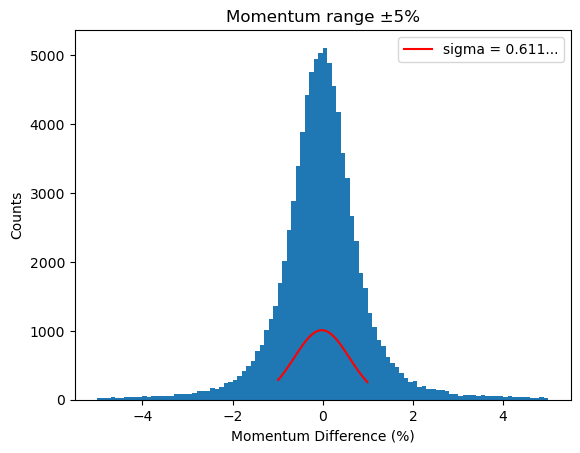

With a +-5% range, there is a bigger distribution of momentum difference over larger amounts of counts, I would think this is worse.


In [49]:
plt.hist(df['p_diff'],bins=100,range=(-5,5))
plt.plot(x,gaussian(x,*params),label='sigma = 0.611...',color='red')
plt.xlabel('Momentum Difference (%)')
plt.ylabel('Counts')
plt.title('Momentum range ±5%')
plt.legend()
plt.show()
print("With a +-5% range, there is a bigger distribution of momentum difference over larger amounts of counts, I would think this is worse.")

# Problem 4A)

In Problem 3 we computed the momentum resolution by integrating over the entire momentum and $\eta$ range. However, the tracking performance could change as function of both momentum and $\eta$. 

To access how the momentum resolution changes as a function of $\eta$, we will split our *p_diff* values into three $\eta$ regions:
* Backward: $\eta < -1$
* Central: $|\eta| < 1$
* Forward: $\eta > 1$

Create three new DataFrames that contain the momentum difference values for the specified $\eta$ ranges and then create histograms showing the momentum difference in each of these $\eta$ regions. When working with the $\eta$ values, use eta_gen values.

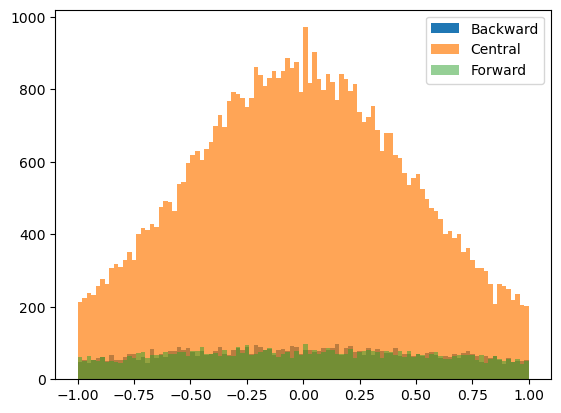

In [55]:
backward=df[df['eta_gen']<-1]
central=df[(-1<=df['eta_gen'])&(df['eta_gen']<=1)]
forward=df[df['eta_gen']>1]
plt.hist(backward['p_diff'],bins=100,range=(-1, 1),label='Backward')
plt.hist(central['p_diff'],bins=100,range=(-1, 1),alpha=0.7,label='Central')
plt.hist(forward['p_diff'],bins=100,range=(-1, 1),alpha=0.5,label='Forward')
plt.legend()
plt.show()

# Problem 4B)

Fit each of the 3 $\eta$ regions with a Gaussian function to get a more quantatative idea of how the resolution changes as a function of $\eta$. For this fit you can use the range -5% to 5% and **do not** need to calculate $\chi^2$ or a p-value for this problem.

Your 3 fitted histograms shoul look like this:
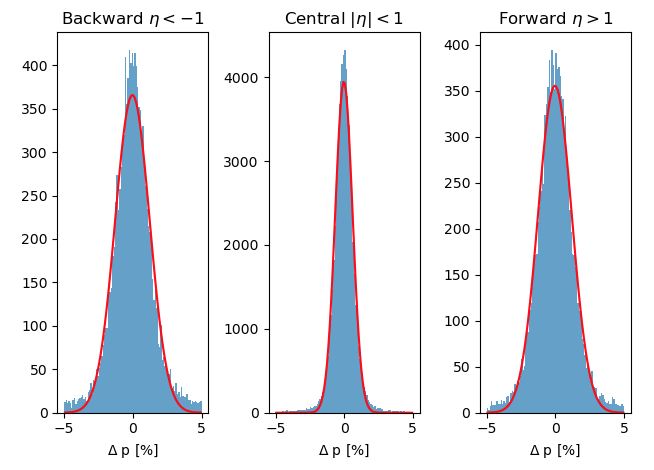

**Q: What region provides the best momentum resolution?** 

**Q: What region provides the worst momentum resolution?** 

Backward region: p3 (resolution) = 1.1475401083101486


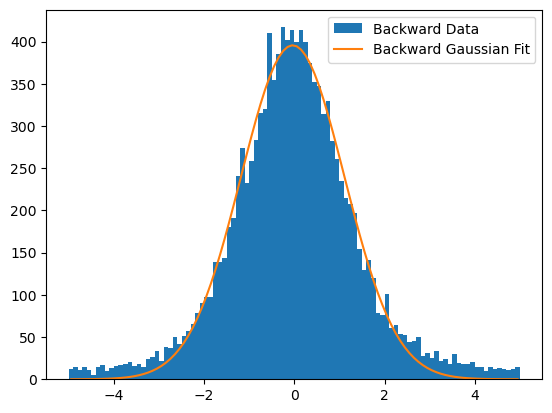

Central region: p3 (resolution) = 0.5807795072867136


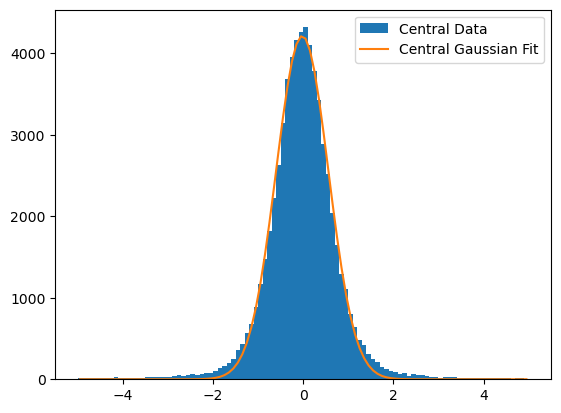

Forward region: p3 (resolution) = 1.1457769231358064


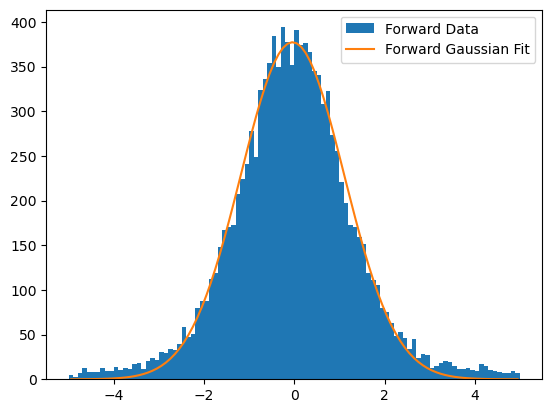

Forward region seems to have the highest momentum resolution, while the central data has the lowest resolution


In [51]:
def fit_and_plot(data,label):
    counts,bin_edges=np.histogram(data['p_diff'],bins=100,range=(-5, 5))
    x=(bin_edges[1:]+bin_edges[:-1])/2
    y=counts
    y_error=np.sqrt(y)
    params, _=curve_fit(gaussian,x,y,p0=initial_parameters)
    print(f"{label} region: p3 (resolution) = {params[2]}")
    plt.hist(data['p_diff'],bins=100,range=(-5, 5),label=f'{label} Data')
    plt.plot(x,gaussian(x,*params),label=f'{label} Gaussian Fit')
    plt.legend()
    plt.show()
fit_and_plot(backward, 'Backward')
fit_and_plot(central, 'Central')
fit_and_plot(forward, 'Forward')
print('Forward region seems to have the highest momentum resolution, while the central data has the lowest resolution')

# Problem 5A)

In Problem 4 we investigated how the momentum resolution changes as a function of $\eta$. The momentum resolution is also dependent on the momentum of the particle being detectoed. In this problem we will look at the momentum dependence of the momentum resolution.

To access how the momentum resolution changes as a function of *p_gen*, we will split our *p_diff* values into three 5 momentum regions: (0,2), (2,4), (4,6), (6,8), (8,10)

Create five new DataFrames that contain the momentum difference values for the specified *p_gen* ranges and then create histograms showing the momentum difference in each of these p_gen regions. 

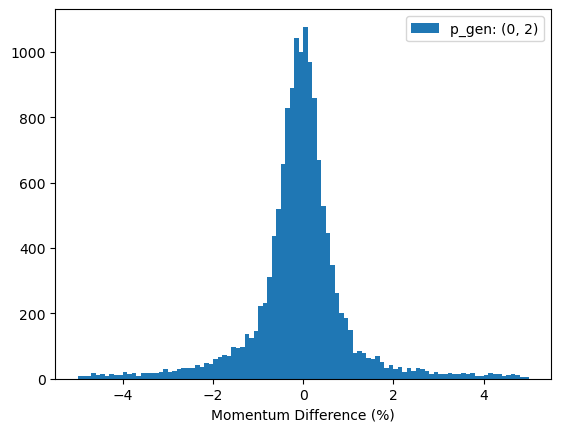

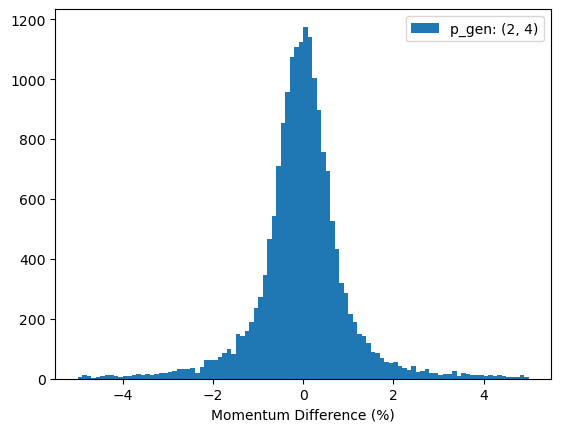

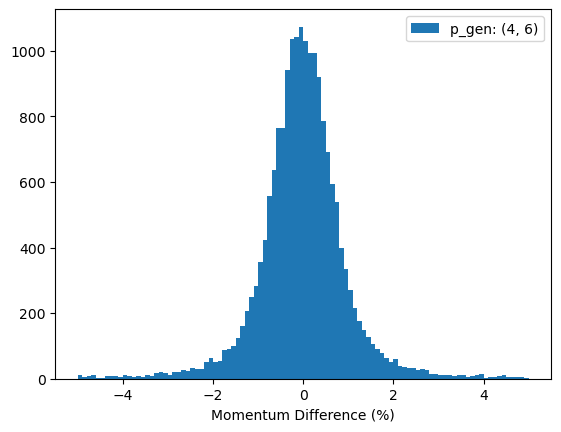

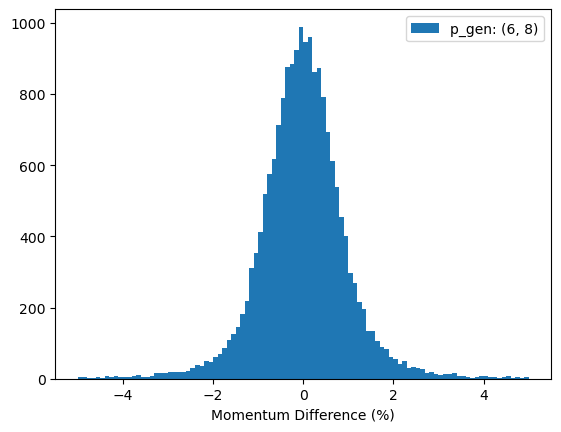

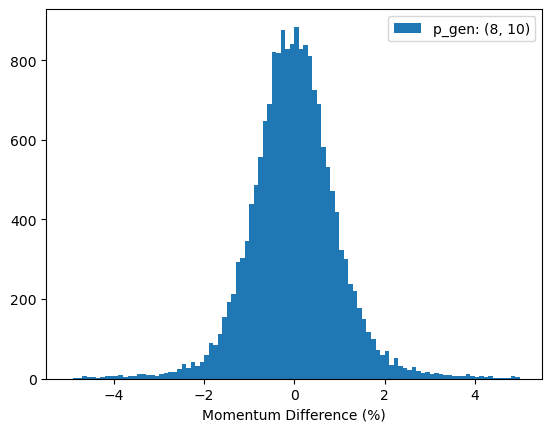

In [52]:
regions=[(0,2),(2,4),(4,6),(6,8),(8,10)]
for region in regions:
    df_region=df[(df['p_gen']>=region[0])&(df['p_gen']<region[1])]
    plt.hist(df_region['p_diff'],bins=100,range=(-5,5),label=f'p_gen: {region}')
    plt.xlabel('Momentum Difference (%)')
    plt.legend()
    plt.show()

# Problem 5B)

Fit each of the 5 momentum regions with a Gaussian function to get a more quantatative idea of how the resolution changes as a function of p_gen. For this fit you can use the range -5% to 5% and **do not** need to calculate $\chi^2$ or a p-value for this problem.

Your 5 fitted histograms should look like this:
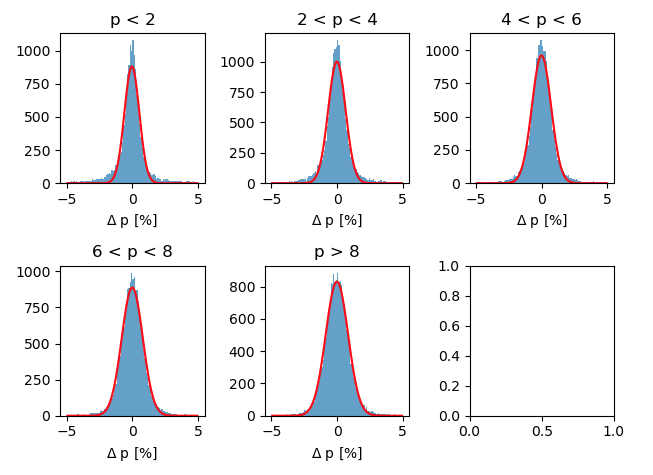

**Q: What region provides the best momentum resolution?**

**Q: What region provides the worst momentum resolution?**


p_gen: (0, 2) region: p3 (resolution) = 0.4873817765556213


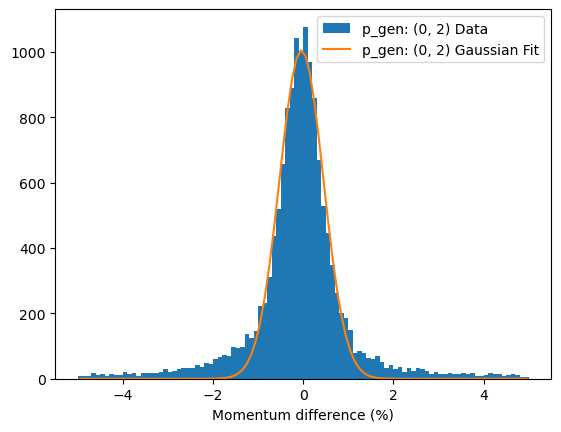

p_gen: (2, 4) region: p3 (resolution) = 0.577793638512705


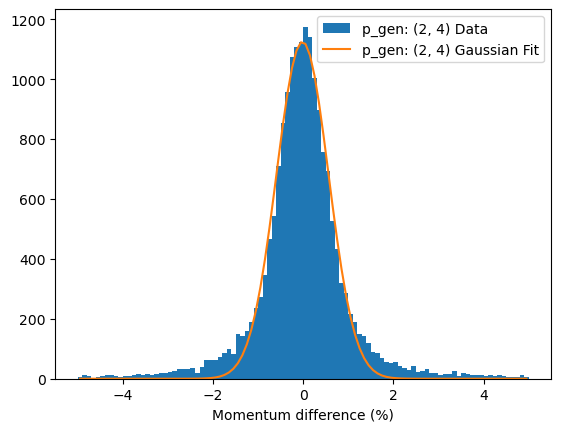

p_gen: (4, 6) region: p3 (resolution) = 0.6616089662617805


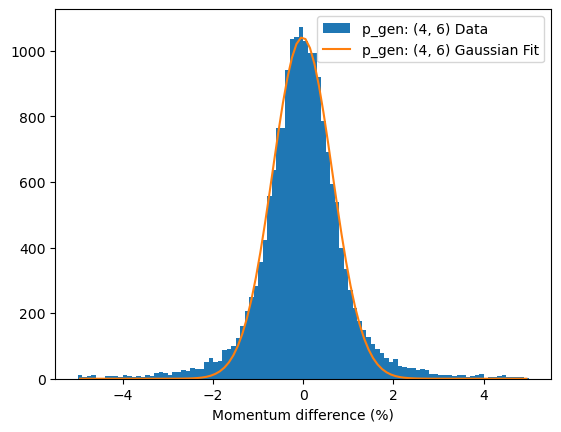

p_gen: (6, 8) region: p3 (resolution) = 0.7454432513846658


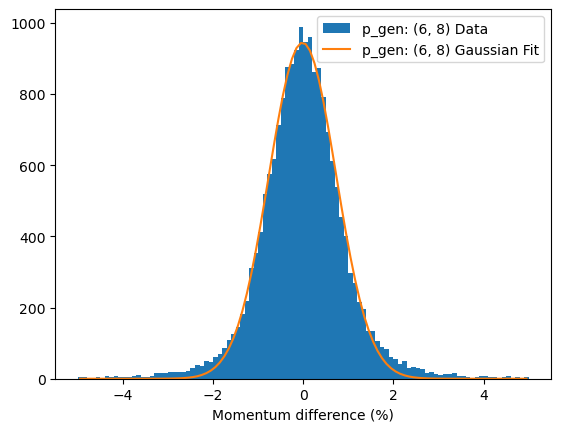

p_gen: (8, 10) region: p3 (resolution) = 0.8069554211393116


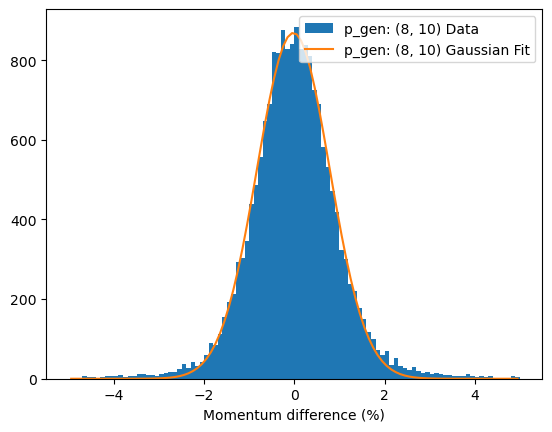

The best resolution was from P_gen: (8,10), and the worst was from P_gen:(0,2)


In [53]:
for region in regions:
    df_region=df[(df['p_gen']>=region[0])&(df['p_gen']<region[1])]
    plt.xlabel('Momentum difference (%)')
    fit_and_plot(df_region, f'p_gen: {region}')
print('The best resolution was from P_gen: (8,10), and the worst was from P_gen:(0,2)')